# Prep data

In [608]:
import numpy as np
from os import listdir

chrom = 'Y'
#chrom = '18'
#family_id = 'AU3368'
family_id = 'AU0412'
mother_id = 'AU0412202'
father_id = 'AU0412201'

sample_file = 'split_gen/chr.%s.gen.samples.txt' % chrom
ped_file = 'data/v34.forCompoundHet.ped'
gen_files = sorted([f for f in listdir('split_gen') if ('chr.%s' % chrom) in f and 'gen.npz' in f])
variant_file = 'split_gen/chr.%s.gen.variants.txt.gz' % chrom

print(gen_files)

# map individuals to row index in matrix
with open(sample_file, 'r') as f:
    ind_to_index = dict([(line.strip(), i) for i, line in enumerate(f)])

['chr.Y.gen.npz']


In [609]:
# pull individual ids for family
child_ids = []
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, f_id, m_id = pieces[0:4]
        if fam_id == family_id:
            print(pieces)
            if f_id == father_id and m_id == mother_id:
                child_ids.append(child_id)
                
family_indices = [ind_to_index[i] for i in [mother_id, father_id] + child_ids]
print(family_indices)

['AU0412', 'AU0412301', 'AU0412201', 'AU0412202', '2', '2']
['AU0412', 'AU0412302', 'AU0412201', 'AU0412202', '2', '0', 'DZ v']
['AU0412', 'AU0412303', 'AU0412201', 'AU0412202', '1', '2', 'DZ v']
[1025, 1024, 1027, 1026, 1038]


In [610]:
from scipy import sparse

# pull genotype data from .npz
whole_chrom = sparse.hstack([sparse.load_npz('split_gen/%s' % gen_file) for gen_file in gen_files])
m, n = whole_chrom.shape
print(m, n)

4610 254524


In [ ]:
# Look for missing regions in the reference genome
import gzip

def read_chrom(ref_genome, chrom):
    seq = []
    with gzip.open(ref_genome, 'rt') as reffile:
        in_chr = False
        for line in reffile:
            if '>' in line:
                print(line)
                in_chr = line.endswith('>chr%s\n' % chrom)
            elif in_chr:
                seq.append(line.strip())
    return seq

ref_genome = 'hg_reference/chromFA.tar.gz'
refseq = read_chrom(ref_genome, chrom)

#n_positions, n_lengths = [], []
#n_start_pos, n_length = -1, 1

#for i, c in enumerate(rc):
#    if c == 'N' and n_start_pos == -1:
#        n_start_pos = i+1
#    elif c == 'N':
#        n_length += 1
#    elif n_start_pos != -1:
#        n_positions.append(n_start_pos)
#        n_lengths.append(n_length)
#        n_start_pos = -1
#        n_length = 1
        
#if n_start_pos != -1:
#    n_positions.append(n_start_pos)
#    n_lengths.append(n_length)

In [611]:
import gzip
import math

def get_ref(pos):
    line_size = len(refseq[0])
    return refseq[math.floor((pos-1)/line_size)][((pos-1) % line_size)]

# pull indices of snps
snp_indices = []
snp_positions = []
with gzip.open(variant_file, 'rt') as f:
    for i, line in enumerate(f):
        pieces = line.strip().split('\t')
        if len(pieces[3]) == 1 and len(pieces[4]) == 1 and pieces[3] != '.' and pieces[4] != '.':
            #if pieces[3] != get_ref(int(pieces[1])).upper():
            #    print(line, get_ref(int(pieces[1])))
            #else:
            snp_indices.append(i)
            snp_positions.append(int(pieces[1]))

In [542]:
# pull positions and length of 'N' sequences
n_positions, n_lengths = [], []
n_start_index = -1
n_length = 1
current_index = 1
for line in refseq:
    for c in line:
        if c == 'N' or c == 'n':
            if n_start_index == -1:
                n_start_index = current_index
            else:
                n_length += 1
        else:
            if n_start_index != -1:
                n_positions.append(n_start_index)
                n_lengths.append(n_length)
                n_start_index, n_length = -1, 1
        current_index += 1

if n_start_index != -1:
    n_positions.append(n_start_index)
    n_lengths.append(n_length)
                
print(len(n_positions))

KeyboardInterrupt: 

In [508]:
print(n_positions)
print(n_lengths)

[1, 94822, 231385, 1047558, 1134114, 1264235, 2068239, 7623883, 10738675, 37098257, 49242998, 49974174, 52395915, 58582013, 76653693, 113517669, 115682291, 120013236, 143507325]
[60000, 50000, 50000, 50000, 50000, 50000, 50000, 50000, 50000, 50000, 50000, 50000, 50000, 3100000, 50000, 50000, 50000, 50000, 50000]


In [612]:
# pull snps for this family
family_genotypes = whole_chrom[np.ix_(family_indices, snp_indices)].A

# filter out all_hom_ref
family_indices = ~np.all(family_genotypes == 0, axis=0)
family_genotypes = family_genotypes[:, family_indices]

family_snp_positions = np.array(snp_positions)[family_indices]
m, n = family_genotypes.shape
print(family_genotypes.shape)

(5, 192918)


In [510]:
missing_intervals = np.zeros((n+1,), dtype=int)
n_intervals = np.zeros((n+1,), dtype=int)

# count intervals between known positions
missing_intervals[0] = family_snp_positions[0]-1
missing_intervals[1:-1] = (family_snp_positions[1:] - family_snp_positions[:-1]) - 1
missing_intervals[-1] = sum([len(x) for x in refseq]) - family_snp_positions[-1]

i = 0
final_ns = 0
for n_start_pos, n_length in zip(n_positions, n_lengths):
    while i < n and family_snp_positions[i] < n_start_pos:
        i += 1
        
    while i < n and family_snp_positions[i] < (n_start_pos+n_length):
        print(family_snp_positions[i], n_start_pos, n_start_pos+n_length, family_genotypes[:, i])
        i += 1
        
    #print(n_start_pos, n_start_pos+n_length, -1 if i==n else family_snp_positions[i], i)
    if i == n:
        final_ns += n_length
    else:
        n_intervals[i] += n_length
n_intervals[n] = final_ns
        
print(np.sum(n_intervals), sum(n_lengths))
print(n_intervals.shape, n_intervals)
print(missing_intervals.shape, missing_intervals)

normal_to_normal_cost = n_intervals
missing_to_missing_cost = missing_intervals - n_intervals

7624715 7623883 7673883 [2 2 2 2 2]
7624894 7623883 7673883 [2 2 2 2 2]
7627269 7623883 7673883 [0 1 1 1 1]
7627343 7623883 7673883 [2 2 2 2 2]
7628303 7623883 7673883 [2 1 1 1 1]
7629512 7623883 7673883 [2 2 2 2 2]
7631621 7623883 7673883 [1 2 1 2 1]
7632078 7623883 7673883 [2 1 1 1 1]
7633657 7623883 7673883 [2 2 2 2 2]
7634550 7623883 7673883 [2 2 2 2 2]
7637487 7623883 7673883 [2 2 2 2 2]
7644754 7623883 7673883 [2 2 2 2 2]
7653959 7623883 7673883 [0 0 0 1 0]
7654353 7623883 7673883 [0 0 0 1 0]
7654534 7623883 7673883 [0 0 0 1 0]
7654631 7623883 7673883 [0 0 0 1 0]
7654890 7623883 7673883 [0 0 0 1 0]
7654960 7623883 7673883 [0 0 0 1 0]
7655324 7623883 7673883 [0 0 0 1 0]
7655327 7623883 7673883 [0 0 0 1 0]
7655833 7623883 7673883 [1 0 0 1 1]
7656008 7623883 7673883 [1 1 0 1 1]
7656161 7623883 7673883 [1 1 0 1 1]
7656418 7623883 7673883 [1 1 0 1 1]
7656619 7623883 7673883 [1 1 0 1 1]
7656684 7623883 7673883 [1 1 0 1 1]
7656972 7623883 7673883 [1 1 0 1 1]
7657006 7623883 7673883 [1 1

58885068 58582013 61682013 [ 0 -1  0  0  0]
58885081 58582013 61682013 [0 2 0 0 0]
58885089 58582013 61682013 [1 0 2 2 2]
58885154 58582013 61682013 [2 2 2 2 2]
58885225 58582013 61682013 [0 2 0 0 0]
58885242 58582013 61682013 [0 2 0 0 0]
58885251 58582013 61682013 [0 2 0 0 0]
58885290 58582013 61682013 [2 0 2 2 2]
58885447 58582013 61682013 [1 0 2 2 2]
58885456 58582013 61682013 [2 0 2 2 2]
58886929 58582013 61682013 [1 2 0 0 0]
58887330 58582013 61682013 [ 0  0  0  0 -1]
58887477 58582013 61682013 [1 2 0 0 0]
58887611 58582013 61682013 [1 2 0 0 0]
58887646 58582013 61682013 [0 2 0 0 0]
58890051 58582013 61682013 [0 0 0 0 1]
58890075 58582013 61682013 [0 0 0 0 1]
58890080 58582013 61682013 [0 0 0 0 1]
58890128 58582013 61682013 [0 2 0 0 0]
58890214 58582013 61682013 [0 2 0 0 0]
58890255 58582013 61682013 [1 2 0 0 0]
58890493 58582013 61682013 [0 2 0 0 0]
58890715 58582013 61682013 [1 2 0 0 0]
58890723 58582013 61682013 [1 2 0 0 0]
58890966 58582013 61682013 [0 2 0 0 0]
58891091 585820

58976648 58582013 61682013 [1 0 2 2 2]
58976726 58582013 61682013 [1 0 0 0 0]
58976740 58582013 61682013 [0 2 0 0 0]
58976742 58582013 61682013 [1 0 0 0 0]
58976743 58582013 61682013 [1 0 2 2 2]
58976821 58582013 61682013 [1 0 0 0 0]
58976837 58582013 61682013 [1 0 0 0 0]
58976856 58582013 61682013 [1 0 2 2 2]
58977015 58582013 61682013 [1 0 0 0 0]
58977040 58582013 61682013 [2 0 2 2 2]
58977110 58582013 61682013 [1 0 2 2 2]
58977113 58582013 61682013 [1 0 2 2 2]
58977168 58582013 61682013 [1 0 2 2 2]
58977169 58582013 61682013 [1 0 2 2 2]
58977174 58582013 61682013 [1 0 2 2 2]
58977315 58582013 61682013 [2 0 2 2 2]
58977382 58582013 61682013 [2 0 2 2 2]
58977388 58582013 61682013 [2 0 2 2 2]
58977633 58582013 61682013 [2 0 2 2 2]
58977654 58582013 61682013 [2 0 2 2 1]
58977830 58582013 61682013 [1 0 0 0 0]
58977844 58582013 61682013 [2 0 2 2 2]
58977907 58582013 61682013 [2 0 2 2 2]
58977952 58582013 61682013 [2 0 2 2 2]
58977958 58582013 61682013 [2 0 2 2 2]
58978129 58582013 6168201

58992468 58582013 61682013 [1 0 2 2 2]
58992767 58582013 61682013 [1 0 0 0 0]
58993085 58582013 61682013 [0 0 1 0 0]
58993096 58582013 61682013 [0 0 1 0 0]
58993110 58582013 61682013 [0 0 1 0 0]
58993115 58582013 61682013 [0 0 1 0 0]
58993179 58582013 61682013 [0 2 0 0 0]
58993187 58582013 61682013 [1 0 2 2 2]
58993247 58582013 61682013 [1 0 2 2 2]
58993250 58582013 61682013 [2 2 2 2 2]
58993276 58582013 61682013 [0 2 0 0 0]
58993296 58582013 61682013 [1 2 0 0 0]
58993316 58582013 61682013 [2 2 2 2 2]
58993348 58582013 61682013 [0 2 0 0 0]
58993400 58582013 61682013 [0 2 0 0 0]
58993407 58582013 61682013 [1 0 2 2 2]
58993514 58582013 61682013 [1 0 0 0 0]
58993561 58582013 61682013 [1 0 0 0 0]
58993781 58582013 61682013 [2 2 2 2 2]
58993865 58582013 61682013 [1 0 2 2 2]
58993952 58582013 61682013 [1 0 2 2 2]
58993963 58582013 61682013 [1 2 0 0 0]
58993981 58582013 61682013 [1 2 0 0 0]
58993998 58582013 61682013 [1 0 2 2 2]
58994005 58582013 61682013 [1 2 0 0 0]
58994007 58582013 6168201

59031063 58582013 61682013 [1 2 0 0 0]
59031191 58582013 61682013 [-1 -1 -1 -1 -1]
59031198 58582013 61682013 [-1 -1 -1 -1 -1]
59031209 58582013 61682013 [2 2 2 2 2]
59031451 58582013 61682013 [1 0 0 0 0]
59031665 58582013 61682013 [1 0 2 2 2]
59031689 58582013 61682013 [2 2 2 2 2]
59031694 58582013 61682013 [2 2 2 2 2]
59031726 58582013 61682013 [2 2 2 2 2]
59032267 58582013 61682013 [2 0 2 2 2]
59032367 58582013 61682013 [0 2 0 0 0]
59032381 58582013 61682013 [0 2 0 0 0]
59032461 58582013 61682013 [0 2 0 0 0]
59032547 58582013 61682013 [0 2 0 0 0]
59032566 58582013 61682013 [0 2 0 0 0]
59032592 58582013 61682013 [0 2 0 0 0]
59032696 58582013 61682013 [0 2 0 0 0]
59032976 58582013 61682013 [1 0 0 0 0]
59033068 58582013 61682013 [2 0 2 2 2]
59033084 58582013 61682013 [2 0 2 2 2]
59033093 58582013 61682013 [ 0  0 -1  0 -1]
59033155 58582013 61682013 [2 0 2 2 2]
59033247 58582013 61682013 [2 0 2 2 2]
59033441 58582013 61682013 [2 0 2 2 2]
59033463 58582013 61682013 [2 0 2 2 2]
59033470 5

# Prep inheritance states, genotypes, etc

In [613]:
from sklearn.utils.extmath import cartesian

# generate all possible inheritance states

# for family:
# (0) -> normal
# (1) -> het
#
# for parents:
# (0, 0) -> normal
# (0, 1) -> deletion on parental2
# (1, 0) -> deletion on parental1
# (1, 1) -> deletion on parental1 and parental2
# 
# for children:
# (0, 0) -> m1p1
# (0, 1) -> m1p2
# (1, 0) -> m2p1
# (1, 1) -> m2p2

cart_list = [[0]] + [[0, 1]]*4 + [[0, 1]]*(2*m-4)
print(cart_list)
inheritance_states = np.array(cartesian(cart_list), dtype=np.int8)

state_to_index = dict([(tuple(x), i) for i, x in enumerate(inheritance_states)])
p = inheritance_states.shape[0]
print(inheritance_states.shape)


[[0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
(1024, 11)


In [635]:
from collections import defaultdict, Counter

# generate all possible genotypes
cart_list = [[-1, 0, 1, 2]]*m
print(cart_list)
genotypes = np.array(cartesian(cart_list), dtype=np.int8)
genotype_to_index = dict([(tuple(x), i) for i, x in enumerate(genotypes)])
q = genotypes.shape[0]
print(genotypes.shape)


g_neighbors = {0: [1],
               1: [0, 2],
               2: [1],
               -1: [0, 1, 2]}

g_equivalents = {0: [0, -1],
                 1: [1, -1],
                 2: [2, -1],
                -1: [-1]}

g_hsr_equivalents = {0: [0, -1],
                     1: [1, -1, 0, 2],
                     2: [2, -1],
                    -1: [-1]}

# map genotypes to neighbors and equivalents
genotype_to_neighbors = []
genotype_to_equivalents = []
genotype_to_hsr_equivalents = []

for g in genotypes:
    neighbor_gs = []
    for j in range(m):
        for new_entry in g_neighbors[g[j]]:
            new_genotype = tuple(new_entry if k == j else x for k, x in enumerate(g))
            neighbor_gs.append(genotype_to_index[new_genotype])
    genotype_to_neighbors.append(neighbor_gs)   
    
    genotype_to_equivalents.append([genotype_to_index[tuple(x)] for x in cartesian([g_equivalents[x] for x in g])]) 
    genotype_to_het_equivalents.append([genotype_to_index[tuple(x)] for x in cartesian([g_het_equivalents[x] for x in g])])  
    genotype_to_hsr_equivalents.append([genotype_to_index[tuple(x)] for x in cartesian([g_hsr_equivalents[x] for x in g])])  
    
print(Counter([len(x) for x in genotype_to_neighbors]))

[[-1, 0, 1, 2], [-1, 0, 1, 2], [-1, 0, 1, 2], [-1, 0, 1, 2], [-1, 0, 1, 2]]
(1024, 5)
Counter({9: 210, 8: 200, 10: 161, 7: 160, 11: 105, 6: 80, 12: 50, 5: 32, 13: 20, 14: 5, 15: 1})


In [637]:
import random
g = random.randint(0, genotypes.shape[0])
print(genotypes[g, :])
print(genotypes[genotype_to_equivalents[g], :])
print(genotypes[genotype_to_neighbors[g], :])

[2 1 2 0 0]
[[ 2  1  2  0  0]
 [ 2  1  2  0 -1]
 [ 2  1  2 -1  0]
 [ 2  1  2 -1 -1]
 [ 2  1 -1  0  0]
 [ 2  1 -1  0 -1]
 [ 2  1 -1 -1  0]
 [ 2  1 -1 -1 -1]
 [ 2 -1  2  0  0]
 [ 2 -1  2  0 -1]
 [ 2 -1  2 -1  0]
 [ 2 -1  2 -1 -1]
 [ 2 -1 -1  0  0]
 [ 2 -1 -1  0 -1]
 [ 2 -1 -1 -1  0]
 [ 2 -1 -1 -1 -1]
 [-1  1  2  0  0]
 [-1  1  2  0 -1]
 [-1  1  2 -1  0]
 [-1  1  2 -1 -1]
 [-1  1 -1  0  0]
 [-1  1 -1  0 -1]
 [-1  1 -1 -1  0]
 [-1  1 -1 -1 -1]
 [-1 -1  2  0  0]
 [-1 -1  2  0 -1]
 [-1 -1  2 -1  0]
 [-1 -1  2 -1 -1]
 [-1 -1 -1  0  0]
 [-1 -1 -1  0 -1]
 [-1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1]]
[[1 1 2 0 0]
 [2 0 2 0 0]
 [2 2 2 0 0]
 [2 1 1 0 0]
 [2 1 2 1 0]
 [2 1 2 0 1]]


In [638]:
# generate all possible ancestral_variants
anc_variants = np.array(cartesian([[0, 1]]*4))
anc_variant_to_index = dict([(tuple(x), i) for i, x in enumerate(anc_variants)])
print(anc_variants.shape)

(16, 4)


# Prep transition matrix and cost matrix

In [639]:
from collections import defaultdict, Counter

# transition matrix
# only allow one shift at a time
shift_costs = [10] + [10]*4 + [200]*(2*(m-2))

valid_transitions = [[i] for i in range(p)]
transition_costs = [[0] for i in range(p)]
for i, state in enumerate(inheritance_states):
    for j in range(len(shift_costs)):
        for k in range(state[j]):
            new_state = tuple(k if i == j else x for i, x in enumerate(state))
            if new_state in state_to_index:
                new_index = state_to_index[new_state]
                valid_transitions[i].append(new_index)
                transition_costs[i].append(shift_costs[j])
                valid_transitions[new_index].append(i)
                transition_costs[new_index].append(shift_costs[j])
            
restricted_transitions = np.array(valid_transitions)
restricted_transition_cost = np.array(transition_costs)
print(restricted_transitions.shape)

(1024, 11)


In [618]:
pos_transition_cost = np.asarray([[inheritance_states[to_state, 0] != 0 and inheritance_states[from_state, 0] != 0 for from_state in x] for to_state, x in enumerate(valid_transitions)], dtype=int)
print(pos_transition_cost)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [583]:
miss_transition_cost = np.asarray([[inheritance_states[to_state, 0] == 0 and inheritance_states[from_state, 0] == 0 for from_state in x] for to_state, x in enumerate(valid_transitions)], dtype=int)
print(miss_transition_cost)

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


In [640]:
from itertools import chain

# loss matrix
losses = np.zeros((p, q)) - 1

for i, s in enumerate(inheritance_states):
    
    # what genotypes can be validly produced from this inheritance state?          
    valid_genotypes = np.zeros((anc_variants.shape[0], m), dtype=int)
        
    # mom
    if s[1] == 0 and s[2] == 0:
        valid_genotypes[:, 0] = anc_variants[:, 0] + anc_variants[:, 1]
    elif s[1] == 0:
        valid_genotypes[:, 0] = 2*anc_variants[:, 0]
    elif s[2] == 0:
        valid_genotypes[:, 0] = 2*anc_variants[:, 1]
    else:
        valid_genotypes[:, 0] = -1
            
    # dad
    if s[3] == 0 and s[4] == 0:
        valid_genotypes[:, 1] = anc_variants[:, 2] + anc_variants[:, 3]
    elif s[3] == 0:
        valid_genotypes[:, 1] = 2*anc_variants[:, 2]
    elif s[4] == 0:
        valid_genotypes[:, 1] = 2*anc_variants[:, 3]
    else:
        valid_genotypes[:, 1] = -1
        
    # children
    for index in range(m-2):
        mat, pat = s[(5+(2*index)):(7+(2*index))]
        
        if s[1+mat] == 0 and s[3+pat] == 0:
            valid_genotypes[:, 2+index] = anc_variants[:, mat] + anc_variants[:, 2+pat]
        elif s[1+mat] == 0:
            valid_genotypes[:, 2+index] = 2*anc_variants[:, mat]
        elif s[3+pat] == 0:
            valid_genotypes[:, 2+index] = 2*anc_variants[:, 2+pat]
        else:
            valid_genotypes[:, 2+index] = -1

    valid_genotypes = set([genotype_to_index[tuple(x)] for x in valid_genotypes]) 
    
    if s[0] == 0:
        equimap = genotype_to_equivalents
    elif s[0] == 1:
        # in a hard to sequence region, -1s are ok
        equimap = genotype_to_hsr_equivalents

    # breadth first search to fill in loss for this state
    current_cost = 0
    while len(valid_genotypes) > 0:
        # add equivalents
        valid_genotypes = valid_genotypes | set(chain.from_iterable([equimap[x] for x in valid_genotypes]))

        next_gen = set()
        for g in valid_genotypes:
            # fill in loss matrix
            if losses[i, g] == -1:
                losses[i, g] = current_cost

                # pull next generation
                next_gen.update([ng for ng in genotype_to_neighbors[g] if losses[i, ng] == -1])

        valid_genotypes = next_gen
        current_cost += 1  
        
losses[inheritance_states[:, 0] == 1, 1:] += 2
    
                
# Check if we've missed some
print(np.sum(losses == -1)/(losses.shape[0]*losses.shape[1]))

0.0


//anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


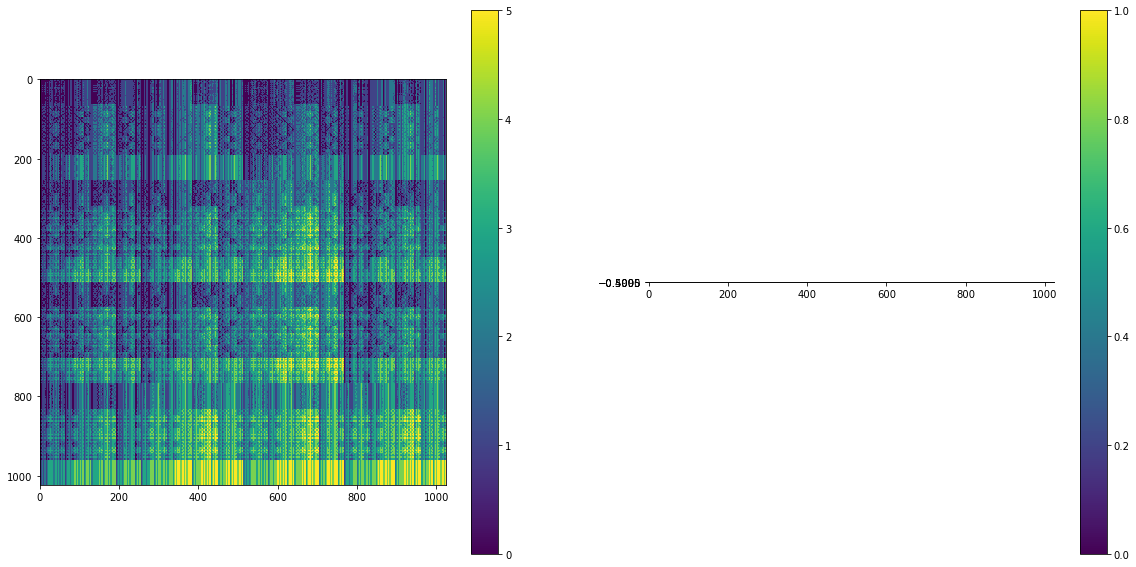

In [641]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(losses[inheritance_states[:, 0] == 0, :])
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(losses[inheritance_states[:, 0] == 1, :])
plt.colorbar()

plt.show()

# Viterbi

In [621]:
v_cost = np.zeros((p, n+2), dtype=int)
v_traceback = np.zeros((p, n+2), dtype=int)

In [622]:
import time

# forward sweep
prev_time = time.time()
pos_to_genindex = [genotype_to_index[tuple(x)] for x in family_genotypes.T]

v_traceback[:, 0] = -1
for j in range(n): 
    
    total_cost = v_cost[restricted_transitions, j] + restricted_transition_cost #\
    #    + (normal_to_normal_cost[j]*pos_transition_cost) \
    #    + (missing_to_missing_cost[j]*miss_transition_cost)
    min_index = np.argmin(total_cost, axis=1)
    v_traceback[:, j+1] = restricted_transitions[range(p), min_index]
    v_cost[:, j+1] = total_cost[range(p), min_index] + losses[:, pos_to_genindex[j]]

    if j % 100000 == 0:
        print(j)

# last step
total_cost = v_cost[restricted_transitions, n] + restricted_transition_cost #\
   #     + (normal_to_normal_cost[n]*pos_transition_cost) \
   #     + (missing_to_missing_cost[n]*miss_transition_cost)
min_index = np.argmin(total_cost, axis=1)
v_traceback[:, n+1] = restricted_transitions[range(p), min_index]
v_cost[:, n+1] = total_cost[range(p), min_index]
    
print('Forward sweep complete', time.time()-prev_time, 'sec') 

0
100000
Forward sweep complete 92.93081593513489 sec


In [623]:
print(v_cost[:, n+1])

[12979 12779 12779 ..., 12817 12816 13017]


In [624]:
# Backward sweep
prev_time = time.time()
index = n+1
k = np.argmin(v_cost[:, index])
print(list(zip(*np.unique(v_cost[:, index], return_counts=True))))

final_states = np.zeros((n+2,), dtype=int)
while index >= 0:
    final_states[index] = k    
    k = v_traceback[k, index]
    index -= 1
    
print('Backward sweep complete', time.time()-prev_time, 'sec') 
print(final_states)

[(12579, 4), (12587, 4), (12588, 4), (12589, 8), (12596, 4), (12597, 8), (12598, 8), (12599, 4), (12606, 8), (12607, 4), (12608, 4), (12616, 4), (12777, 4), (12779, 20), (12785, 4), (12786, 8), (12787, 24), (12788, 24), (12789, 36), (12794, 4), (12795, 8), (12796, 36), (12797, 36), (12798, 44), (12799, 16), (12804, 8), (12805, 4), (12806, 44), (12807, 20), (12808, 20), (12814, 4), (12816, 16), (12817, 4), (12977, 12), (12979, 24), (12985, 12), (12986, 24), (12987, 36), (12988, 36), (12989, 36), (12994, 12), (12995, 24), (12996, 72), (12997, 36), (12998, 60), (12999, 12), (13004, 20), (13005, 16), (13006, 64), (13007, 20), (13008, 24), (13014, 8), (13015, 4), (13016, 16), (13017, 8)]
Backward sweep complete 0.11879777908325195 sec
[3 3 3 ..., 3 3 3]


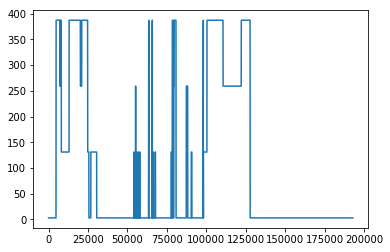

In [625]:
plt.plot(final_states)
plt.show()

In [626]:
final_loss = np.zeros((n+2,), dtype=int)
final_loss[1:-1] = losses[final_states[1:-1], pos_to_genindex]

for i in range(1, n+2):
    from_state = final_states[i-1]
    to_state = final_states[i]
    
    #if inheritance_states[from_state][0] == 0 and inheritance_states[to_state][0] == 0:
    #    final_loss[i] += normal_to_normal_cost[i-1]
    #elif inheritance_states[from_state][0] == 1 and inheritance_states[to_state][0] == 1:
    #    final_loss[i] += missing_to_missing_cost[i-1]
        
print(final_loss)

[0 0 0 ..., 0 0 0]


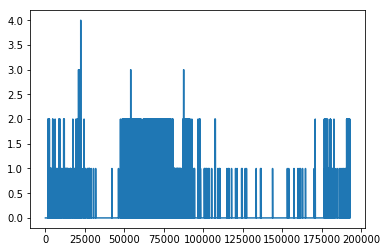

In [627]:
plt.plot(final_loss)
plt.show()

In [628]:
print(v_cost[final_states[1], 1])
print(inheritance_states[final_states[0]], inheritance_states[final_states[-1]])

0
[0 0 0 0 0 0 0 0 0 1 1] [0 0 0 0 0 0 0 0 0 1 1]


[  4727   4728   4728   4729   7135   7136   7278   7279   8048   8049
  12986  12987  20128  20129  20997  20998  24761  24762  25536  25537
  26782  26783  30478  30479  54007  54008  54133  54134  55088  55089
  55233  55234  55971  55972  56049  56050  56919  56920  57094  57095
  57749  57750  57786  57787  63350  63351  63426  63427  63534  63535
  63541  63542  65468  65469  65680  65681  65754  65755  65765  65766
  65995  65996  66306  66307  67498  67499  67771  67772  77768  77769
  77920  77921  78298  78299  78393  78394  78736  78737  78785  78786
  79385  79386  79595  79596  80771  80772  80793  80794  87260  87261
  88181  88182  90422  90423  90811  90812  97940  97941  98044  98045
  98089  98090  98090  98091  98158  98159 100373 100374 110580 110581
 122111 122112 127730 127731 127731]
[  4727   4728   4728   4729   7135   7136   7278   7279   8048   8049
  12986  12987  20128  20129  20997  20998  24761  24762  25536  25537
  26782  26783  30478  30479  54007  540

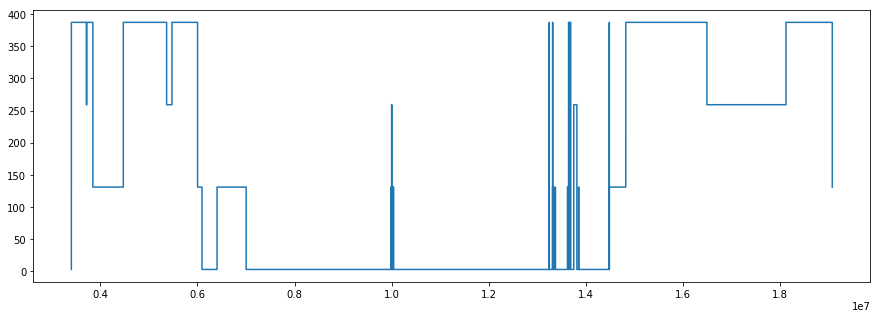

In [629]:
xs = np.where(final_states[1:]-final_states[:-1] != 0)[0]
xs = np.concatenate((xs, xs[:-1]+1))
xs = np.sort(xs)
print(xs)
ys = final_states[xs]
pos = [sum([len(x) for x in refseq]) if x==n else family_snp_positions[x] for x in xs]

print(xs, ys)

plt.figure(figsize=(15, 5))
plt.plot(pos, ys)
plt.show()

In [630]:
print('\n'.join(['%d\t%s'  % (x, str(tuple(inheritance_states[y, :]))) for x, y in zip(xs[:20], ys[:20])]))

4727	(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1)
4728	(0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1)
4728	(0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1)
4729	(0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1)
7135	(0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1)
7136	(0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1)
7278	(0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1)
7279	(0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1)
8048	(0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1)
8049	(0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1)
12986	(0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1)
12987	(0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1)
20128	(0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1)
20129	(0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1)
20997	(0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1)
20998	(0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1)
24761	(0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1)
24762	(0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1)
25536	(0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1)
25537	(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1)


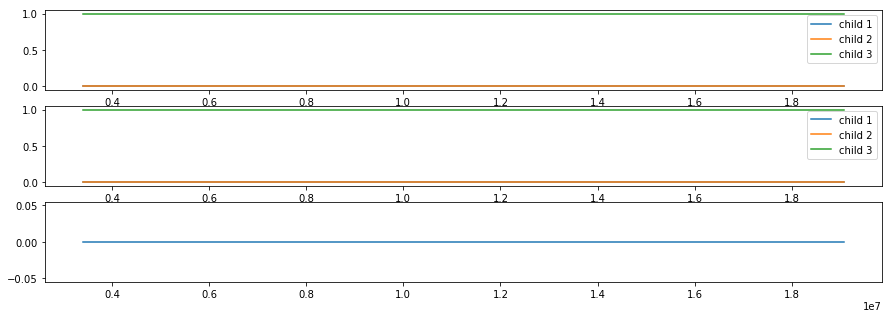

In [631]:
# Children
plt.figure(figsize=(15, 5))
for i in range(m-2):
    plt.subplot(3, 1, 1)
    plt.plot(pos, [inheritance_states[y, 5 + (i*2)] for y in ys], label='child %d' % (i+1))
    
    plt.subplot(3, 1, 2)
    plt.plot(pos, [inheritance_states[y, 6 + (i*2)] for y in ys], label='child %d' % (i+1))

plt.subplot(3, 1, 3)
plt.plot(pos, [inheritance_states[y, 0] for y in ys])

plt.subplot(3, 1, 1)
plt.legend()
plt.subplot(3, 1, 2)
plt.legend()
plt.show()
    

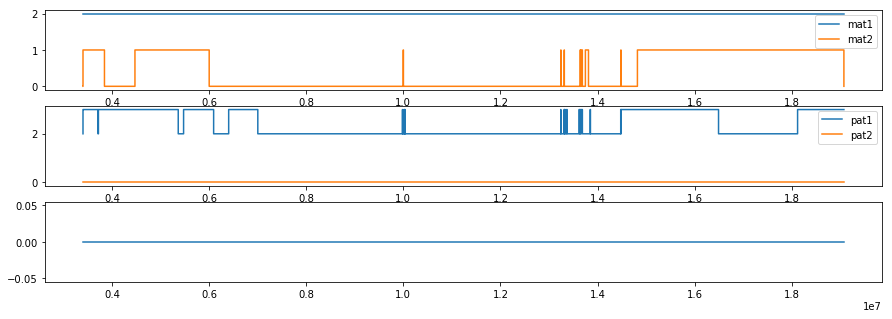

In [632]:
# Parents
plt.figure(figsize=(15, 5))

plt.subplot(3, 1, 1)
plt.plot(pos, [inheritance_states[y, 1]+2 for y in ys], label='mat1')
plt.plot(pos, [inheritance_states[y, 2] for y in ys], label='mat2')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(pos, [inheritance_states[y, 3]+2 for y in ys], label='pat1')
plt.plot(pos, [inheritance_states[y, 4] for y in ys], label='pat2')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(pos, [inheritance_states[y, 0] for y in ys])

plt.show()

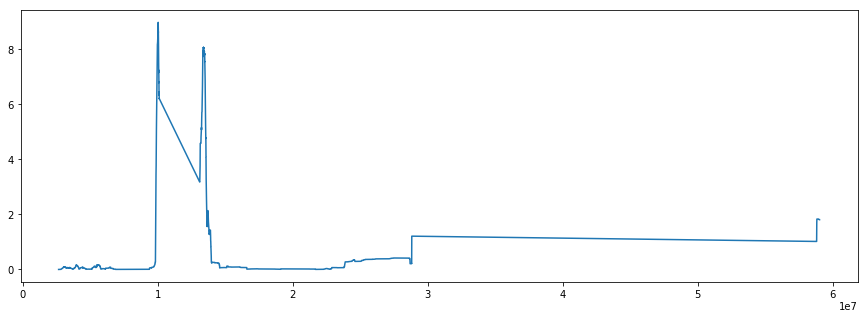

In [633]:
c = 100000

plt.figure(figsize=(15, 5))
plt.plot(family_snp_positions, 1000*sparse_convolve(family_snp_positions, final_loss[1:-1], c)/(c*m))
#plt.ylabel('Errors per person per kilobase (smoothed)')
#plt.plot(family_snp_positions, np.convolve(complex_model_final_loss, np.ones((c,))/(m*c), mode='same'))

#plt.plot(family_snp_positions, 100*sparse_convolve(family_snp_positions, np.sum(family_genotypes == -1, axis=0), c)/(c*m))
#plt.plot(family_snp_positions, np.convolve(np.sum(family_genotypes == -1, axis=0), np.ones((c,))/(m*c), mode='same'))
#plt.plot(np.convolve(simple_model_final_loss, np.ones((c,))/(m*c), mode='same'))
plt.show()

In [53]:
def sparse_convolve(pos, vs, c):
    new_signal = np.zeros(pos.shape)
   
    current_index = 0
    start_index = 0
    running_sum = 0
            
    for end_position, v in zip(pos, vs):
        if end_position - pos[current_index] > c:
            new_signal[current_index] = running_sum
            current_index += 1
            
            # clean up end
            while pos[current_index] - pos[start_index] > c:
                running_sum -= vs[start_index]
                start_index += 1
            
        running_sum += v
        
    for current_index in range(current_index, pos.shape[0]):
        new_signal[current_index] = running_sum        
            
        # clean up end
        while pos[current_index] - pos[start_index] > c:
            running_sum -= vs[start_index]
            start_index += 1
            
    return new_signal
        

(59218,)
[[0 0 0 1 0 0 0 0 0 1 1]]
[[0 0 1 1 0 0 0 0 0 1 1]]
[[0 0 0 1 0 0 0 0 0 1 1]
 [0 0 1 1 0 0 0 0 0 1 1]]


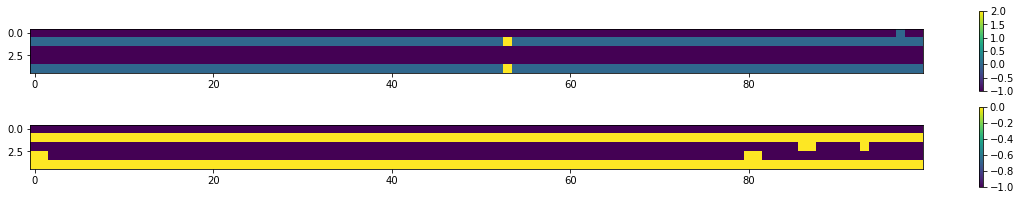

In [634]:
# take a look at deletions
deletion_indices = np.where(np.any(inheritance_states[final_states, 1:5] == 1, axis=1))[0]
print(deletion_indices.shape)

plt.figure(figsize=(20, 5))

plt.subplot(3, 1, 1)
plt.imshow(family_genotypes[:, 30000:30100])
plt.colorbar()
print(inheritance_states[np.unique(final_states[30000:30100]), :])


plt.subplot(3, 1, 2)
plt.imshow(family_genotypes[:, (deletion_indices[100]-100):deletion_indices[100]])
plt.colorbar()

print(inheritance_states[np.unique(final_states[deletion_indices[100:200]]), :])

print(inheritance_states[np.unique(final_states[(deletion_indices[100]-100):(deletion_indices[100])]), :])

plt.show()

3035200 - 3050544
[[0 0 0 0 0 0 0 1 0 0 0]]


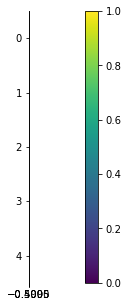

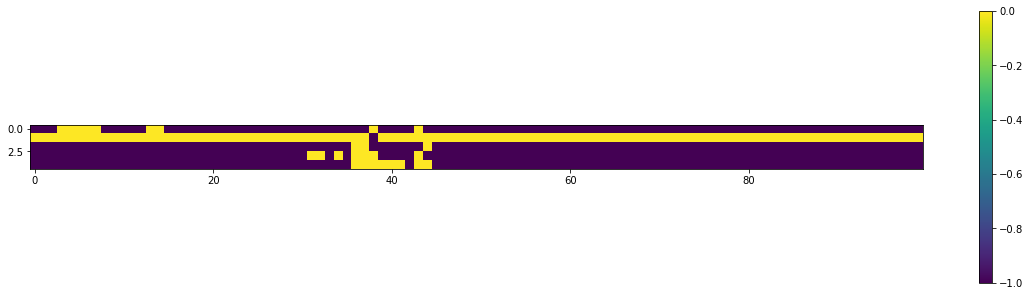

In [534]:
# take a look at bad regions
bad_regions = np.where(1000*sparse_convolve(family_snp_positions, final_loss, c)/(c*m) >= .1)[0]

# take a look at deletions
deletion_indices = np.where(np.any(inheritance_states[final_states, 1:5] == 1, axis=1))[0]

plt.figure(figsize=(20, 5))

start, end = 0, 100
plt.subplot(1, 1, 1)
plt.imshow(family_genotypes[:, bad_regions[start:end]])
plt.colorbar()

#plt.subplot(3, 1, 2)
#plt.imshow(family_genotypes[:, (bad_regions[0]-100):bad_regions[0]])
#plt.colorbar()

print(family_snp_positions[bad_regions[start]], '-', family_snp_positions[bad_regions[end]])
print(inheritance_states[np.unique(final_states[bad_regions[start:end]]), :])

#print(inheritance_states[np.unique(final_states[(bad_regions[0]-100):(bad_regions[0])]), :])

plt.show()


In [137]:
plt.figure(figsize=(10, 5))
bad_region_loss = losses[:, np.array(pos_to_genindex)[bad_regions[200:300]]]
total_state_cost = np.sum(bad_region_loss, axis=1)

best_indices = total_state_cost.argsort()[:5]
for i in best_indices:
    plt.plot(np.convolve(bad_region_loss[i, :], np.ones((10,))/10, mode='same'), label=str(tuple(inheritance_states[i, :])))

interest_index = state_to_index[(1,) + (0,)*(2*m)]
plt.plot(np.convolve(bad_region_loss[interest_index, :], np.ones((10,))/10, mode='same'), label=str(tuple(inheritance_states[interest_index, :])))
plt.legend()
plt.show()

ValueError: v cannot be empty